In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
)

np.random.seed(42)

In [ ]:
paths = pd.read_csv('../paths.csv', index_col=0)

# Load full MAE embeddings dataset
embeddings_path = paths.loc["embeddings"].iloc[0] + "embeddings_cls.csv"
embeddings = pd.read_csv(embeddings_path)

# Load label file (e.g., 3-year cancer data)
labels = pd.read_csv("/vol/miltank/projects/ukbb/projects/practical_ss25_icl/disease_filtered_data_3year/cancer_timerange_3year.csv")

# Binary label: 1 = cancer within 3 years
labels['label'] = 1  # All rows are positive cases

# Create negatives (non-cancer group) by selecting EIDs not in the positive group
healthy_data = pd.read_csv("../data/healthy_train.csv")
healthy_data = healthy_data[~healthy_data['eid'].isin(labels['eid'])]
healthy_data['label'] = 0

# Combine positive and negative samples
classification_df = pd.concat([labels[['eid', 'label']], healthy_data[['eid', 'label']]], axis=0)

# Merge with features
data = classification_df.merge(embeddings, on='eid', how='inner')

X = data[[f'feature_{i}' for i in range(1025)]]
y = data['label']

In [3]:
X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

In [4]:
clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

Accuracy: 0.7105263157894737
Precision: 0.6062992125984252
Recall: 0.2862453531598513
F1 Score: 0.3888888888888889
ROC AUC: 0.724120296611003


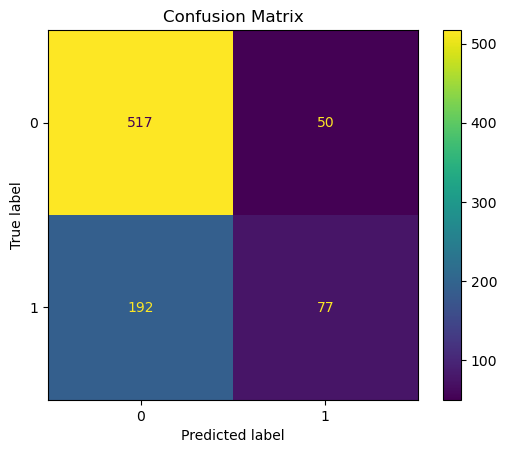

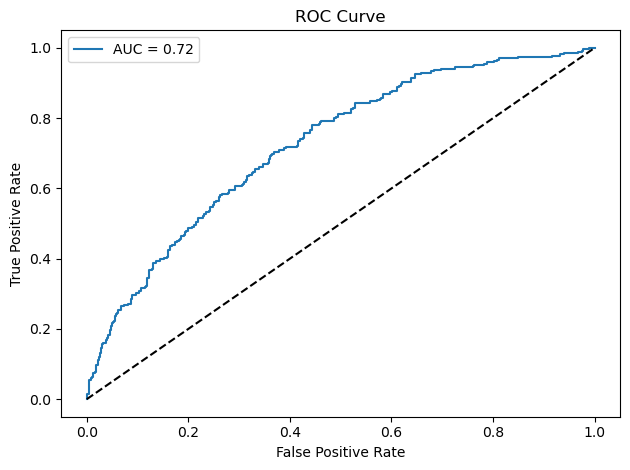

In [5]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()